# Assignment 2

![](src/Problem_description.png)

## Task 1

![](src/Task1.png)

![](src/scheme.jpg)

So our first 2 equations will look like this: 
$\left\{\begin{array}{l}
0=\mathbf{f}_{1}+\mathbf{f}_{2}+\mathbf{f}_{3}+\mathbf{f}_{4}+m \mathbf{g} \\
0=\sum_{i=1}^{4}\left(\mathbf{r}_{i}-\mathbf{r}_{C}\right) \times \mathbf{f}_{i}
\end{array}\right.$

Cross product can be replaced with this matrix: $[\mathbf{a}]_{\times}=\left[\begin{array}{rcc}
0 & -a_{3} & a_{2} \\
a_{3} & 0 & -a_{1} \\
-a_{2} & a_{1} & 0
\end{array}\right]$

We need one more equation to get constrain about friction: 
$\left\|\mathbf{E}_{t}^{\top} \mathbf{f}_{i}\right\| \leq \mu \mathbf{e}_{n}^{\top} \mathbf{f}_{i}$  
where $\mathbf{E}_{t}$ is orthonormal basis in the tangential space to the surface; and $\mathbf{e}_{n}$ is the norm of the surface.

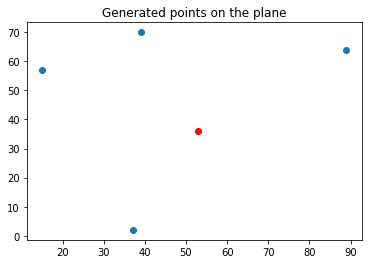

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import random
import cvxpy as cp
np.set_printoptions(suppress=True)

skew_matrix = lambda v: np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

g = np.array([0, 0, -9.8])
m = 1
mu = 0.8

plane_norm = np.array([0, 0, 1])[:, None]
plane = null_space(plane_norm.T)

# Generate points on 2D surface
r_2d = np.array([random.sample(range(0, 100), 2) for i in range(4)])
rc_2d= np.array(random.sample(range(30, 60), 2))

# Put generated 2D points on 3D surface
r = r_2d[:, 0][:, None] * plane[:, 0] + r_2d[:, 1][:, None] * plane[:, 1]
rc = rc_2d[0] * plane[:, 0] + rc_2d[1] * plane[:, 1] + random.randint(0, 50) * plane_norm.ravel()

plt.title("Generated points on the plane");
plt.scatter(r_2d[:, 0], r_2d[:, 1]);
plt.scatter(rc_2d[0], rc_2d[1], color='red');

#### Solve the problem using CVXPY

In [6]:
f1 = cp.Variable((3,1))
f2 = cp.Variable((3,1))
f3 = cp.Variable((3,1))
f4 = cp.Variable((3,1))
obj = cp.Minimize(0)

constraints = [f1 + f2 + f3 + f4 + m * g[:, None] == 0,
              skew_matrix(r[0]-rc) @ f1 + \
              skew_matrix(r[1]-rc) @ f2 + \
              skew_matrix(r[2]-rc) @ f3 + \
              skew_matrix(r[3]-rc) @ f4 == 0,
              cp.norm2(plane.T @ f1) <= mu * plane_norm.T @ f1,
              cp.norm2(plane.T @ f2) <= mu * plane_norm.T @ f2,
              cp.norm2(plane.T @ f3) <= mu * plane_norm.T @ f3,
              cp.norm2(plane.T @ f4) <= mu * plane_norm.T @ f4]
prob = cp.Problem(obj, constraints)
result = prob.solve()
if f1.value is not None:
    print("f1 is equal to", f1.value.ravel())
    print("f2 is equal to", f2.value.ravel())
    print("f3 is equal to", f3.value.ravel())
    print("f4 is equal to", f4.value.ravel())
else:
    print("Robot is unstable")

f1 is equal to [-0.         -0.          4.44702416]
f2 is equal to [0.         0.         1.19424437]
f3 is equal to [0.        0.        0.8357098]
f4 is equal to [-0.         -0.          3.32302167]


## Task 2

![](src/Task2.png)

All equatians remains the same. For friction equation we only should change normal of the surface and orthonormal basis of it.  
Matrices *Rx*, *Ry*, *Rz* for rotation:

In [7]:
def Rx(theta):
    return np.array([[1, 0, 0], 
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)], 
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1]])

In [8]:
result = -1

# Rotation angles along asis
angle_x = np.pi/10
angle_y = 0
angle_z = 0

# Generate new tilted surface with legs until robot will stable
while result != 0:
    plane_norm = np.array([0, 0, 1])[:, None]
    plane_norm = Rz(angle_z) @ Ry(angle_y) @ Rx(angle_x) @ plane_norm
    plane = null_space(plane_norm.T)

    # Generate points on 2D surface
    r_2d = np.array([random.sample(range(0, 100), 2) for i in range(4)])
    rc_2d= np.array(random.sample(range(40, 60), 2))
    
    # Put generated 2D points on 3D surface
    r = r_2d[:, 0][:, None] * plane[:, 0] + r_2d[:, 1][:, None] * plane[:, 1]
    # Inverse plane normal if x value is negative
    if plane_norm[2][0] < 0:
        plane_norm *= -1
    rc = rc_2d[0] * plane[:, 0] + rc_2d[1] * plane[:, 1] + random.randint(0, 30) * plane_norm.ravel()
    
    # Solve the problem using CVXPY
    f1 = cp.Variable((3,1))
    f2 = cp.Variable((3,1))
    f3 = cp.Variable((3,1))
    f4 = cp.Variable((3,1))
    obj = cp.Minimize(0)

    constraints = [f1 + f2 + f3 + f4 + m * g[:, None] == 0,
                  skew_matrix(r[0]-rc) @ f1 + \
                  skew_matrix(r[1]-rc) @ f2 + \
                  skew_matrix(r[2]-rc) @ f3 + \
                  skew_matrix(r[3]-rc) @ f4 == 0,
                  cp.norm2(plane.T @ f1) <= mu * plane_norm.T @ f1,
                  cp.norm2(plane.T @ f2) <= mu * plane_norm.T @ f2,
                  cp.norm2(plane.T @ f3) <= mu * plane_norm.T @ f3,
                  cp.norm2(plane.T @ f4) <= mu * plane_norm.T @ f4]
    prob = cp.Problem(obj, constraints)
    result = prob.solve()
    if f1.value is not None:
        print("f1 is equal to", f1.value.ravel())
        print("f2 is equal to", f2.value.ravel())
        print("f3 is equal to", f3.value.ravel())
        print("f4 is equal to", f4.value.ravel())
    else:
        print("Robot is unstable")

f1 is equal to [-0.1566244   0.35059877  6.63517513]
f2 is equal to [ 0.02351666 -0.05202878  1.23871368]
f3 is equal to [ 0.09477604 -0.19741422  1.08470501]
f4 is equal to [ 0.0383317  -0.10115577  0.84140619]


#### Visualize tilted surface

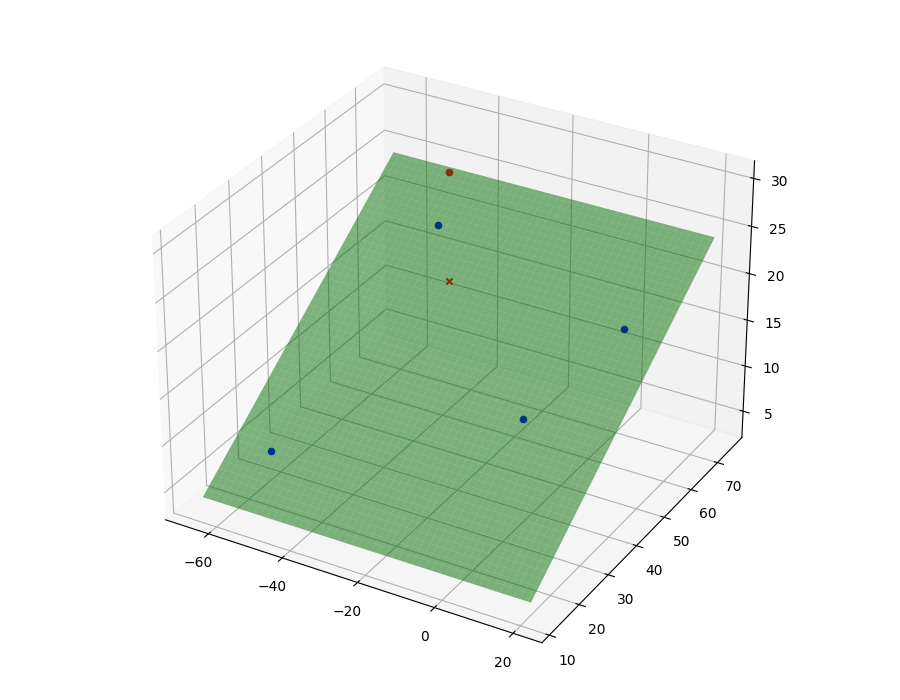

In [9]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams["figure.autolayout"] = True

x = np.linspace(np.min(r,0)[0] - 10, np.max(r,0)[0] + 10, 100)
y = np.linspace(np.min(r,0)[1] - 10, np.max(r,0)[1] + 10, 100) 

x, y = np.meshgrid(x, y)
z = (-plane_norm[0][0] * x - plane_norm[1][0] * y)/plane_norm[2][0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(x, y, z, alpha=0.5, color='green')
for i in range(4):
    ax.scatter(r[i][0], r[i][1], r[i][2], color='blue');
ax.scatter(rc[0], rc[1], rc[2], color='red');

# Add projection of the center mass point to the surface
rc_zproj = (-plane_norm[0][0] * rc[0] - plane_norm[1][0] * rc[1])/plane_norm[2][0]
ax.scatter(rc[0], rc[1], rc_zproj, color='red', marker='x');

plt.show()

## Task 3

![](src/Task3.png)

For this task also only friction equation will be changed. We have to use the correct normal vector and basis vectors depending on where the foot is placed.

In [10]:
result = -1

# Rotation angles along asis
angle_x = np.pi/10
angle_y = 0
angle_z = 0

# Generate new surfaces with legs until robot will stable
while result != 0:
    plane_norm = np.array([0, 0, 1])[:, None]
    plane_norm = Rz(angle_z) @ Ry(angle_y) @ Rx(angle_x) @ plane_norm
    plane = null_space(plane_norm.T)
    # Make x component of the plane basis positive 
    for i in range(plane.shape[1]):
        if plane[0, i] < 0:
            plane[:, i] = -plane[:, i]
    
    # Generate 2D points
    r_2d = np.array([random.sample(range(0, 100), 2) for i in range(2)])
    rc_2d= np.array(random.sample(range(40, 60), 2))

    # Generate 3D points
    r = r_2d[:, 0][:, None] * plane[:, 0] + r_2d[:, 1][:, None] * plane[:, 1]
    if plane_norm[2][0] < 0:
        plane_norm *= -1
    rc = rc_2d[0] * plane[:, 0] + rc_2d[1] * plane[:, 1] + random.randint(0, 30) * plane_norm.ravel()

    # Generate points on the wall
    wall_plane_norm = np.array([1, 0, 0])[:, None]
    wall_plane = null_space(wall_plane_norm.T)
    r_wall_2d = np.array([random.sample(range(0, 100), 2) for i in range(2)])
    r_wall = r_wall_2d[:, 0][:, None] * wall_plane[:, 0] + r_wall_2d[:, 1][:, None] * wall_plane[:, 1]
    r = np.concatenate([r, r_wall])

    # Solve the problem using CVXPY
    f1 = cp.Variable((3,1))
    f2 = cp.Variable((3,1))
    f3 = cp.Variable((3,1))
    f4 = cp.Variable((3,1))
    obj = cp.Minimize(0)

    constraints = [f1 + f2 + f3 + f4 + m * g[:, None] == 0,
                  skew_matrix(r[0]-rc) @ f1 + \
                  skew_matrix(r[1]-rc) @ f2 + \
                  skew_matrix(r[2]-rc) @ f3 + \
                  skew_matrix(r[3]-rc) @ f4 == 0,
                  cp.norm2(plane.T @ f1) <= mu * plane_norm.T @ f1,
                  cp.norm2(plane.T @ f2) <= mu * plane_norm.T @ f2,
                  cp.norm2(wall_plane_norm.T @ f3) <= mu * wall_plane_norm.T @ f3,
                  cp.norm2(wall_plane.T @ f4) <= mu * wall_plane_norm.T @ f4]
    prob = cp.Problem(obj, constraints)
    result = prob.solve()
    if f1.value is not None:
        print("f1 is equal to", f1.value.ravel())
        print("f2 is equal to", f2.value.ravel())
        print("f3 is equal to", f3.value.ravel())
        print("f4 is equal to", f4.value.ravel())
    else:
        print("Robot is unstable")

Robot is unstable
f1 is equal to [-1.55855445 -6.11183078  6.23576565]
f2 is equal to [-5.006412    0.83978955 19.30340105]
f3 is equal to [  0.00000001   1.7195174  -14.98527691]
f4 is equal to [ 6.56496644  3.55252382 -0.7538898 ]


#### Visualize surfaces

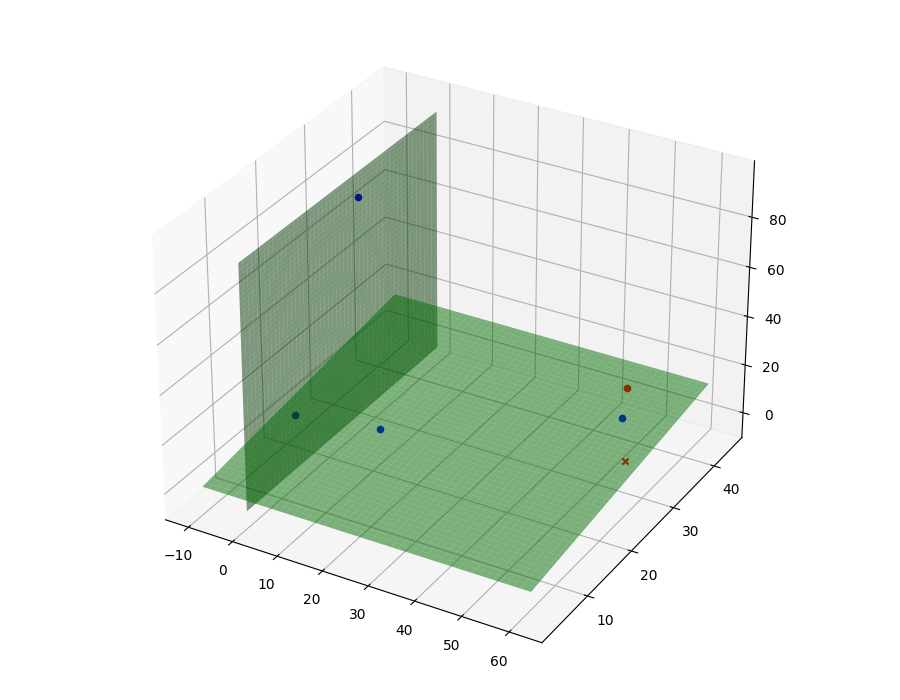

In [11]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot tilted surface
x = np.linspace(np.min(r,0)[0] - 10, np.max(r,0)[0] + 10, 100)
y = np.linspace(np.min(r,0)[1] - 10, np.max(r,0)[1] + 10, 100) 
x, y = np.meshgrid(x, y)
z = (-plane_norm[0][0] * x - plane_norm[1][0] * y)/plane_norm[2][0]
ax.plot_surface(x, y, z, alpha=0.5, color='green')

# Plot wall
y = np.linspace(np.min(r,0)[1] - 10, np.max(r,0)[1] + 10, 100) 
z = np.linspace(min(np.min(r,0)[2], rc[2]) - 10, max(np.max(r,0)[2], rc[2]) + 10, 100) 
y, z = np.meshgrid(y, z)
x = np.zeros_like(y)
ax.plot_surface(x, y, z, alpha=0.5, color='green')

for i in range(4):
    ax.scatter(r[i][0], r[i][1], r[i][2], color='blue');
ax.scatter(rc[0], rc[1], rc[2], color='red');

# Add projection of the center mass point to the surface
rc_zproj = (-plane_norm[0][0] * rc[0] - plane_norm[1][0] * rc[1])/plane_norm[2][0]
ax.scatter(rc[0], rc[1], rc_zproj, color='red', marker='x');
plt.show()

## Task 4

![](src/Task4.png)

In this case we have to consider that the friction is infinite and skip the friction equation for legs that are nailed.

In [12]:
result = -1

# Rotation angles along asis
angle_x = np.pi/10
angle_y = 0
angle_z = 0

# Generate new surfaces with legs until robot will stable
while result != 0:
    plane_norm = np.array([0, 0, 1])[:, None]
    plane_norm = Rz(angle_z) @ Ry(angle_y) @ Rx(angle_x) @ plane_norm
    plane = null_space(plane_norm.T)
    # Make x component of the plane basis positive 
    for i in range(plane.shape[1]):
        if plane[0, i] < 0:
            plane[:, i] = -plane[:, i]
    
    # Generate 2D points
    r_2d = np.array([random.sample(range(0, 100), 2) for i in range(2)])
    rc_2d= np.array(random.sample(range(40, 60), 2))

    # Generate 3D points for the tilted surface
    r = r_2d[:, 0][:, None] * plane[:, 0] + r_2d[:, 1][:, None] * plane[:, 1]
    if plane_norm[2][0] < 0:
        plane_norm *= -1
    rc = rc_2d[0] * plane[:, 0] + rc_2d[1] * plane[:, 1] + random.randint(0, 30) * plane_norm.ravel()

    # Generate 3D points for the wall
    wall_plane_norm = np.array([1, 0, 0])[:, None]
    wall_plane = null_space(wall_plane_norm.T)
    r_wall_2d = np.array([random.sample(range(0, 100), 2) for i in range(2)])
    r_wall = r_wall_2d[:, 0][:, None] * wall_plane[:, 0] + r_wall_2d[:, 1][:, None] * wall_plane[:, 1]
    r = np.concatenate([r, r_wall])

    # Solve the problem using CVXPY
    f1 = cp.Variable((3,1))
    f2 = cp.Variable((3,1))
    f3 = cp.Variable((3,1))
    f4 = cp.Variable((3,1))
    obj = cp.Minimize(0)

    constraints = [f1 + f2 + f3 + f4 + m * g[:, None] == 0,
                  skew_matrix(r[0]-rc) @ f1 + \
                  skew_matrix(r[1]-rc) @ f2 + \
                  skew_matrix(r[2]-rc) @ f3 + \
                  skew_matrix(r[3]-rc) @ f4 == 0,
                  cp.norm2(plane.T @ f1) <= mu * plane_norm.T @ f1,
                  cp.norm2(wall_plane_norm.T @ f3) <= mu * wall_plane_norm.T @ f3,
                  cp.norm2(wall_plane.T @ f4) <= mu * wall_plane_norm.T @ f4]
    prob = cp.Problem(obj, constraints)
    result = prob.solve()
    if f1.value is not None:
        print("f1 is equal to", f1.value.ravel())
        print("f2 is equal to", f2.value.ravel())
        print("f3 is equal to", f3.value.ravel())
        print("f4 is equal to", f4.value.ravel())
    else:
        print("Robot is unstable")

f1 is equal to [ 0.11899569 -0.63814274  1.55681428]
f2 is equal to [-0.8758776   0.40876936  8.58283548]
f3 is equal to [-0.          0.22930064 -0.49303602]
f4 is equal to [0.75688192 0.00007274 0.15338597]


#### Visualize surfaces

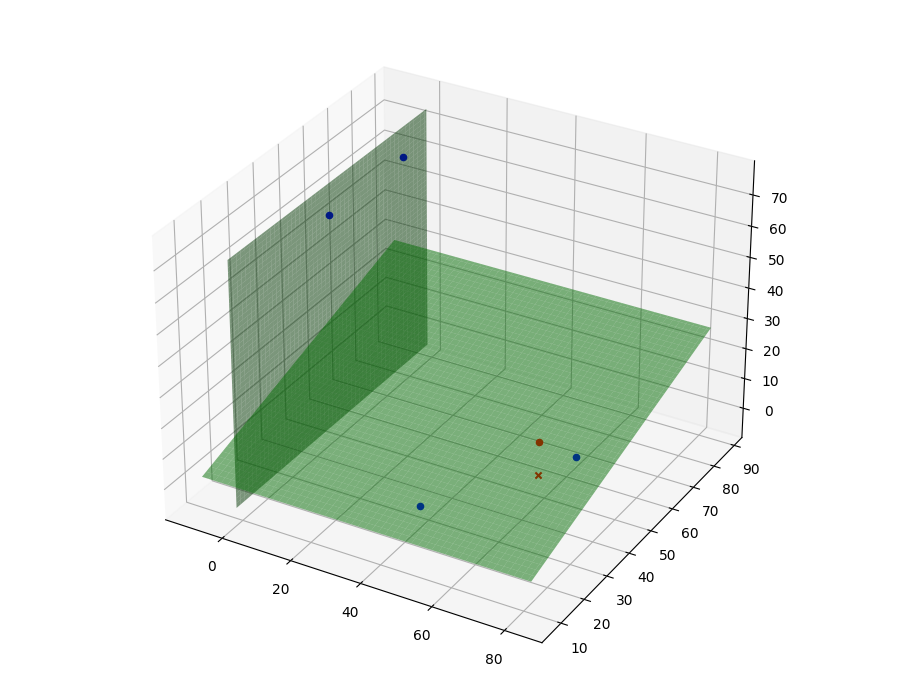

In [13]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = np.linspace(np.min(r,0)[0] - 10, np.max(r,0)[0] + 10, 100)
y = np.linspace(np.min(r,0)[1] - 10, np.max(r,0)[1] + 10, 100) 
x, y = np.meshgrid(x, y)
z = (-plane_norm[0][0] * x - plane_norm[1][0] * y)/plane_norm[2][0]
ax.plot_surface(x, y, z, alpha=0.5, color='green')

y = np.linspace(np.min(r,0)[1] - 10, np.max(r,0)[1] + 10, 100) 
z = np.linspace(min(np.min(r,0)[2], rc[2]) - 10, max(np.max(r,0)[2], rc[2]) + 10, 100) 
y, z = np.meshgrid(y, z)
x = np.zeros_like(y)
ax.plot_surface(x, y, z, alpha=0.5, color='green')

for i in range(4):
    ax.scatter(r[i][0], r[i][1], r[i][2], color='blue');
ax.scatter(rc[0], rc[1], rc[2], color='red');
rc_zproj = (-plane_norm[0][0] * rc[0] - plane_norm[1][0] * rc[1])/plane_norm[2][0]
ax.scatter(rc[0], rc[1], rc_zproj, color='red', marker='x');
plt.show()

## Task 5

![](src/Task5.png)

![](src/Task5.jpg)

![](src/Task5_2.jpg)